In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, 'C:\\Users\\turnerevansd\\Documents\\Python Scripts\\FIBSEM')
import neuPrintFunctions as nPF

## Set up password for neuPrint server (need to paste in your token each time)
import getpass

SERVER = 'emdata1.int.janelia.org:11000'
TOKEN = getpass.getpass()

## Connect to the neuPrint server
from neuprint import Client

c = Client(SERVER, TOKEN)
c.fetch_version()

········


{'Version': '1.0'}

In [2]:
## Specify the type names and bodyIds

## Set thresholds for synapse counts
minSyns = 3

# E-PGs
EPGIds = nPF.typeIds(c, "PB08")
EPGLabels = nPF.typeLabels(c, "PB08")
EPG = nPF.neuronType()
EPG.name = 'EPG'
EPG.regions = ['PB','EB','GA','All']
for nID in range(0, len(EPGIds)):
    EPG.neurons[nID] = nPF.popNeuInst( c, EPGIds[nID], EPGLabels[nID],EPG.regions, minSyns )
    
# P-ENs
PEN1Ids = nPF.typeIds(c, "PB06a")
PEN1Labels = nPF.typeLabels(c, "PB06a")
PEN1 = nPF.neuronType()
PEN1.name = 'PEN1'
PEN1.regions = ['PB','EB','NO','All']
for nID in range(0, len(PEN1Ids)):
    PEN1.neurons[nID] = nPF.popNeuInst( c, PEN1Ids[nID], PEN1Labels[nID], PEN1.regions, minSyns )

PEN2Ids = nPF.typeIds(c, "PB06b")
PEN2Labels = nPF.typeLabels(c, "PB06b")
PEN2 = nPF.neuronType()
PEN2.name = 'PEN2'
PEN2.regions = ['PB','EB','NO','All']
for nID in range(0, len(PEN2Ids)):
    PEN2.neurons[nID] = nPF.popNeuInst( c, PEN2Ids[nID], PEN2Labels[nID], PEN2.regions, minSyns )
    
# P-EGs
PEGIds = nPF.typeIds(c, "PB07")
PEGLabels = nPF.typeLabels(c, "PB07")
PEG = nPF.neuronType()
PEG.name = 'PEG'
PEG.regions = ['PB','EB','GA','All']
for nID in range(0, len(PEGIds)):
    PEG.neurons[nID] = nPF.popNeuInst( c, PEGIds[nID], PEGLabels[nID], PEG.regions, minSyns )
    
# Delta 7s
D7Ids = nPF.typeIds(c, "PB15")
D7Labels = nPF.typeLabels(c, "PB15")
D7 = nPF.neuronType()
D7.name = 'D7'
D7.regions = ['PB','All']
for nID in range(0, len(D7Ids)):
    D7.neurons[nID] = nPF.popNeuInst( c, D7Ids[nID], D7Labels[nID], D7.regions, minSyns ) 
    
# ExR4
ExR4Ids = nPF.typeIds(c, "ExR4")
ExR4Labels = nPF.typeLabels(c, "ExR4")
ExR4 = nPF.neuronType()
ExR4.name = 'ExR4'
ExR4.regions = ['LAL','EB','GA','All']
for nID in range(0, len(ExR4Ids)):
    ExR4.neurons[nID] = nPF.popNeuInst( c, ExR4Ids[nID], ExR4Labels[nID], ExR4.regions, minSyns )
    
# R6
R6Ids = nPF.typeIds(c, "R6")
R6Labels = nPF.typeLabels(c, "R6")
R6 = nPF.neuronType()
R6.name = 'R6'
R6.regions = ['','EB','GA','All']
for nID in range(0, len(R6Ids)):
    R6.neurons[nID] = nPF.popNeuInst( c, R6Ids[nID], R6Labels[nID], R6.regions, minSyns )

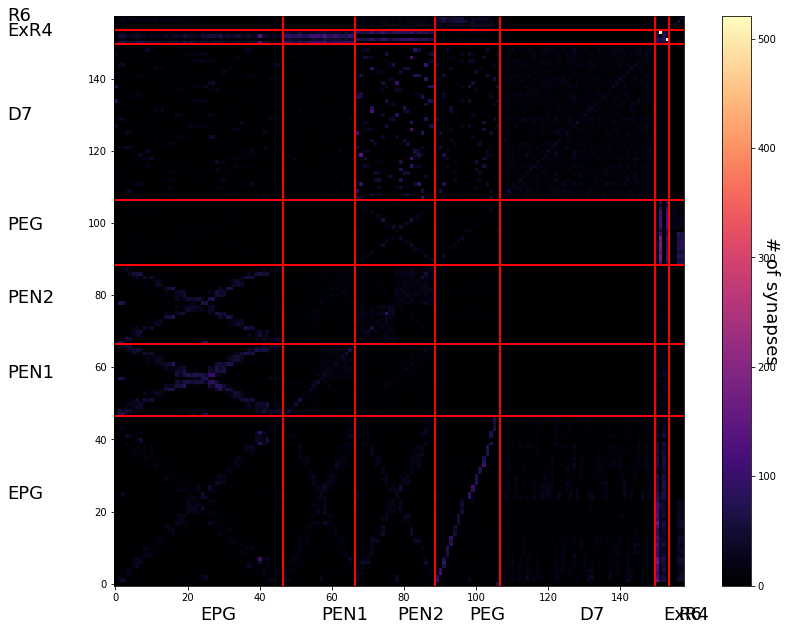

In [16]:
# List the presynaptic types
typeArrayPre = [EPG,PEN1,PEN2,PEG,D7,ExR4,R6]
typeArrayPost = [EPG,PEN1,PEN2,PEG,D7,ExR4,R6]
(connMat, allPreBodyIds, allPreLabels, allPostBodyIds, allPostLabels, totPSDs) = nPF.connMatFill( typeArrayPre, typeArrayPost, 'All')
nPF.connMatPltCounts( typeArrayPre, typeArrayPost, connMat)
print('')

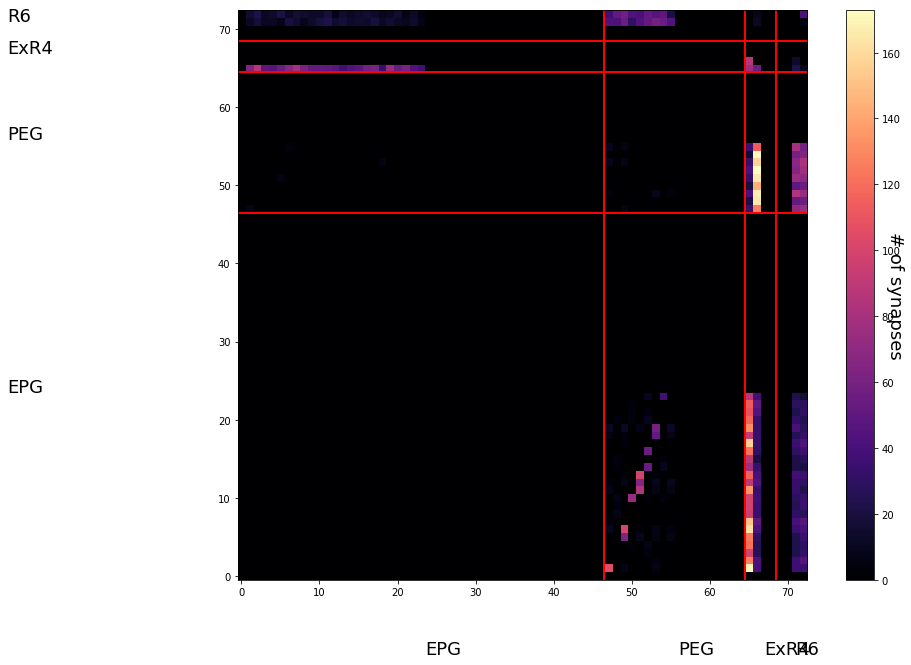

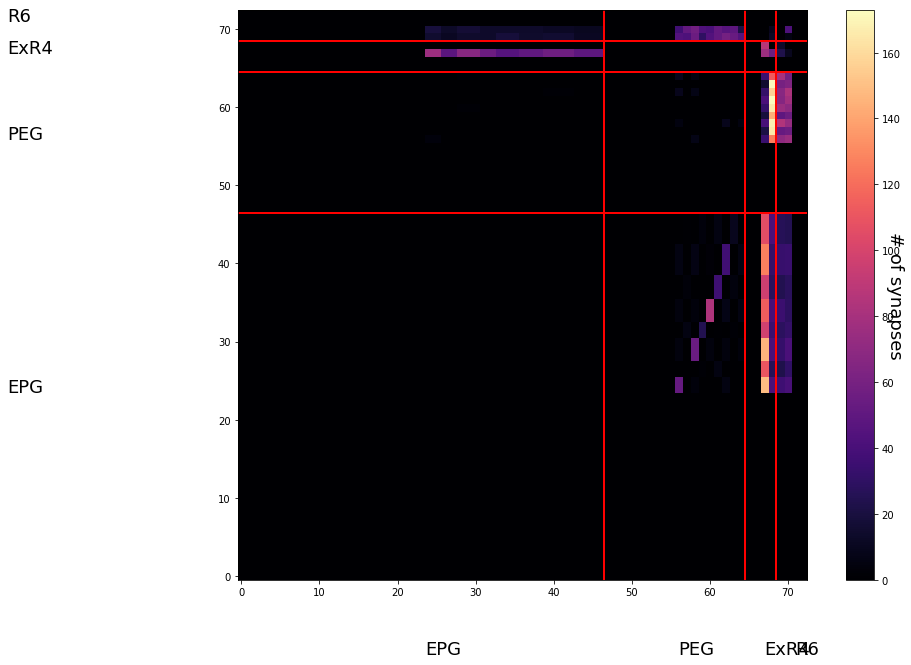

In [17]:
# For neurons where the gall is cut off, replace the empty R connections with their symmetric L counterpart

# Fix the ring neuron names
ExR4.neurons[0].label = 'ExR4(ring)_R_1'
ExR4.neurons[1].label = 'ExR4(ring)_R_2'

# Get the GA wweight matrix
typeArrayPreGA = [EPG,PEG,ExR4,R6]
typeArrayPostGA = [EPG,PEG,ExR4,R6]
(connMatGA, allPreBodyIdsGA, allPreLabelsGA, allPostBodyIdsGA, allPostLabelsGA, totPSDsGA) = nPF.connMatFill( typeArrayPreGA, typeArrayPostGA, 2)
nPF.connMatPltCounts( typeArrayPreGA, typeArrayPostGA, connMatGA)

connMatGANew = np.zeros((len(allPreBodyIdsGA),len(allPostBodyIdsGA)))

# Each neuron of a given class that arborize in the same PB glom. have the same name.
# We only want to look at one of them
lastName = '' 

# Step through the presynaptic neurons
for preN in range(0,len(allPreLabelsGA)):
    # Choose only the neurons that have arbors in the left GA
    if (((allPreLabelsGA[preN].find('E-PG') != -1 or 
        allPreLabelsGA[preN].find('P-EG') != -1) and
        (allPreLabelsGA[preN].find('_L') != -1)) or
        
        ((allPreLabelsGA[preN].find('ExR4') != -1 or
        allPreLabelsGA[preN].find('R6(ring)') != -1) and
        (allPreLabelsGA[preN].find('_R') != -1))):
    
        
        # Check to see if we've already seen one of this name before.
        if allPreLabelsGA[preN] == lastName:
            continue
        else:
            # Find the indices for all neurons with this given name and of their right counterpart
            nronIndices = [i for i,x in enumerate(allPreLabelsGA) if x==allPreLabelsGA[preN]]
            if (allPreLabelsGA[preN].find('E-PG') != -1 or allPreLabelsGA[preN].find('P-EG') != -1):
                cPart = allPreLabelsGA[preN].replace('_L','_R')
            else:
                cPart = allPreLabelsGA[preN].replace('_R','_L')
            nronIndicesCPart = [i for i,x in enumerate(allPreLabelsGA) if x==cPart]
        
        # Step through the postsynaptic neurons
        lastNamePost = ''
        for postN in range(0,len(allPostLabelsGA)):
            if (((allPostLabelsGA[postN].find('E-PG') != -1 or 
                allPostLabelsGA[postN].find('P-EG') != -1) and
                (allPostLabelsGA[postN].find('_L') != -1)) or

                ((allPostLabelsGA[postN].find('ExR4') != -1 or
                allPostLabelsGA[postN].find('R6(ring)') != -1) and
                (allPostLabelsGA[postN].find('_R') != -1))):
                
                # Check to see if we've already seen one of this name before.
                if allPostLabelsGA[postN] == lastNamePost:
                    continue
                else:
                    # Find the indices for all neurons with this given name and of their right counterpart
                    nronIndicesPost = [i for i,x in enumerate(allPostLabelsGA) if x==allPostLabelsGA[postN]]
                    if (allPostLabelsGA[postN].find('E-PG') != -1 or allPostLabelsGA[postN].find('P-EG') != -1):
                        cPartPost = allPostLabelsGA[postN].replace('_L','_R')
                    else:
                        cPartPost = allPostLabelsGA[postN].replace('_R','_L')
                    nronIndicesPostCPart = [i for i,x in enumerate(allPostLabelsGA) if x==cPartPost]
                    
                    # If we can't find a counterpart, skip it
                    if nronIndicesPostCPart == [0]:
                        continue
                
                # Find the mean value of the connection strength between partners
                meanConnVal = 0
                for preInd in range(0,len(nronIndices)):
                    for postInd in range(0,len(nronIndicesPost)):
                        meanConnVal = meanConnVal + connMatGA[nronIndices[preInd],nronIndicesPost[postInd]]
                meanConnVal = meanConnVal/len(nronIndices)/len(nronIndicesPost)
                
                # Fill in that mean value for the counterparts
                for preInd in range(0,len(nronIndicesCPart)):
                    for postInd in range(0,len(nronIndicesPostCPart)):
                        connMatGANew[nronIndicesCPart[preInd],nronIndicesPostCPart[postInd]] = meanConnVal
                
                lastNamePost = allPostLabelsGA[postN]
        
        lastName = allPreLabelsGA[preN]
        
nPF.connMatPltCounts( typeArrayPreGA, typeArrayPostGA, connMatGANew)
print('')

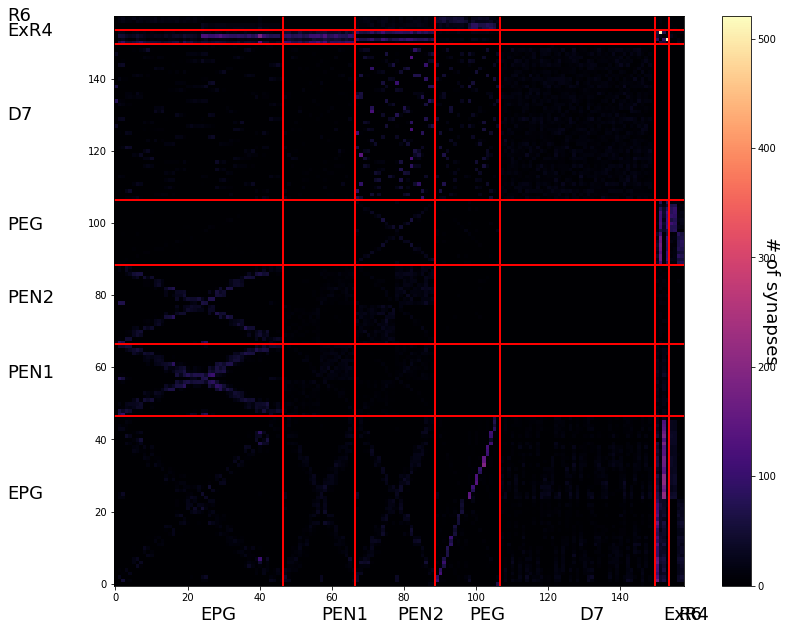

In [18]:
# Add the GA contributions back to the original weight matrix
# Create a new weight matrix to modify
connMatFixed = np.zeros((len(allPreBodyIds),len(allPostBodyIds)))
connMatFixed = connMat

# Step through all of the presynaptic types
preStartGA = 0 # the starting index for each presynaptic type in the GA matrix
for addPre in range(0,len(typeArrayPreGA)):
    if addPre > 0:
        preStartGA = preStartGA + len(typeArrayPreGA[addPre-1].neurons)
        
    # The number of neurons in the presynaptic type
    preLen = len(typeArrayPreGA[addPre].neurons)
    
    # Find the starting index for each presynaptic type in the full matrix
    preStartInd = typeArrayPre.index(typeArrayPreGA[addPre])
    preStart = 0
    if preStartInd == 1:
        preStart = len(typeArrayPre[0].neurons)
    if preStartInd > 1:
        for it in range(0,preStartInd):
            preStart = preStart + len(typeArrayPre[it].neurons)
        
    # Find the overall presynaptic range for both weight matrices
    preRngGA = list(range(preStartGA,preStartGA+preLen-1))
    preRng = list(range(preStart,preStart+preLen-1))
    
    # Step through all of the postsynaptic types
    postStartGA = 0 # the starting index for each postsynaptic type in the GA matrix
    for addPost in range(0,len(typeArrayPostGA)):
        if addPost > 0:
            postStartGA = postStartGA + len(typeArrayPostGA[addPost-1].neurons)
            
        # The number of neurons in the postsynaptic type
        postLen = len(typeArrayPostGA[addPost].neurons)
    
        # Find the starting index for each postsynaptic type in the full matrix
        postStartInd = typeArrayPost.index(typeArrayPostGA[addPost])
        postStart = 0
        if postStartInd == 1:
            postStart = len(typeArrayPost[0].neurons)
        if postStartInd > 1:
            for it in range(0,postStartInd):
                postStart = postStart + len(typeArrayPost[it].neurons)
                    
        postRngGA = list(range(postStartGA,postStartGA+postLen-1))
        postRng = list(range(postStart,postStart+postLen-1))
        
        connMatFixed[np.ix_(preRng,postRng)] = connMatFixed[np.ix_(preRng,postRng)] + connMatGANew[np.ix_(preRngGA,postRngGA)]

# Remove any autapses from the weight matrix
for aRemov in range(0,len(connMatFixed)):
    connMatFixed[aRemov,aRemov] = 0

nPF.connMatPltCounts( typeArrayPre, typeArrayPost, connMatFixed)
print('')